# 18.337 Project: Automatic differentiation methods for nonsmooth functions
Suzane Cavalcanti and Caroline Nielsen

# Project Overview

The fastest and most efficient equation-solving and optimization methods rely on derivative information (e.g. the Jacobian of the equation system, the gradient and Hessian of the objective function) to predict local behavior of smooth functions. Given that analytical derivative formulas are not available in general, these elements have been traditionally approximated with finite differences in many application fields and commercial software. However, this often computationally expensive approach only yields approximate results and is very sensitive to the magnitude of the perturbations. 

On the other hand, automatic differentiation (AD) methods compute exact derivatives or directional derivatives of a function, within machine precision, without needing to perform symbolic differentiation. They can be used to calculate derivatives of existing programs by applying calculus rules to numerical derivatives. In practice, AD algorithms are often implemented using operator overloading, where derivative formulas are defined for elementary operations on value-derivative objects which are used to propagate derivatives in composite functions according to the chain rule.

Several AD algorithms have been implemented in Julia and are available in packages such as AutoGrad and JuliaDiff. These packages encompass both first and second order derivatives, but they can only correctly provide these objects for smooth functions. The goal of this project is to address this limitation by implementing AD methods in Julia that provide useful generalized derivative elements for nonsmooth functions. First-order generalized derivatives for a broad class of nonsmooth functions can be reliably computed with the vector forward AD algorithm of Khan and Barton and the associated LD-derivative object (Khan and Barton 2015). However, Hessian-like elements for non-differentiable scalar-valued functions are not well-defined or even considered in the literature. By extending concepts of Khan and Barton's work, we have developed a novel and promising method to compute exact limiting Hessians for abs-factorable functions (such as min, max, abs, mid and compositions thereof) using a so-defined seconder-order LD-derivative, which will be further studied for future publication.

The following code consists of two parts: the implementation of the first-order forward AD method of Khan and Barton (Khan and Barton 2015), and our own novel second-order forward AD method for nonsmooth functions. For first order derivatives, we have defined a LDder structure which contains a function value and an LD-derivative and we've written a library of base functions that operate on LDder types according to smooth and nonsmooth calculus derivative rulues. The LDder2 type was constructed similarly to handle second derivatives and contains fields for the function value, LD-derivative, and 2nd-order LD-derivative object. The LD-derivative objects can then be found for any arbitrary function using a series of macros.

# The LDder type

In [ ]:
using Pkg
Pkg.add("ForwardDiff")
using LinearAlgebra
using AutoGrad
using ForwardDiff

In [ ]:
struct LDder{v,w}
    val::v
    der::Array{w,1}
end

In [ ]:
# Identifies independent variable for differentiation
struct var{v}
    val::v
end

In [ ]:
# output the number of directions in the LDder
ndir(A::LDder) = length(A.der)
ndir(A::Array) = length(A[1].der)

In [ ]:
# Converts var inputs in an expression to LDderivatives
# If no direction matrix is specified, the identity is used
function derinit(ex::Expr,M)
    args = ex.args
    
    for i in 2:length(args)
        x = args[i]
        
        if isa(x, Expr)
            args[i] = derinit(x,M)
        else
            args[i] = @eval derinit($x,$M)
        end
    end
    eval(ex)
end
function derinit(x::var, M)
    val = x.val 
    lx = length(val)
    X = Array{LDder}(undef,lx)
    
    if M == 0
        M = diagm(0 => ones(lx))
    end
    
    for i = 1:lx
        X[i] = LDder(val[i],M[i,:])
    end
    X
end
derinit(p,M) = p

In [ ]:
# Converts array of LDder structures to separate arrays of values and derivatives
function LD2mat(X::Array)
    lx = length(X)
    nd = ndir(X)
    val = zeros(lx)
    der = zeros(lx,nd)
    for i = 1:lx
        val[i] = X[i].val
        der[i,:] = X[i].der
    end
    val, der
end
function LD2mat(x::LDder)
    val = x.val;
    der = x.der;
    val, der
end

In [ ]:
# Calculates Jacobian from LDder structures
function jacobian(X)
    v,d = LD2mat(X)
    d
end
function jacobian(X::LDder,M)
    v,d = LD2mat(X)
    J = d'*inv(M)
end
function jacobian(X::Array,M)
    v,d = LD2mat(X)
    J = d*inv(M)
end

In [ ]:
# Macro for calculating LDder for existing functions
macro nsdiff(ex, M = 0)
    derinit(ex,M)
end

In [ ]:
# Macros for isolating values, LD-derivatives, and Jacobians from LD-derivative objects
macro val(ex)
    v,d = @eval LD2mat($ex)
    v
end
macro der(ex)
    v,d = @eval LD2mat($ex)
    d
end
macro jacobian(ex)
    @eval jacobian($ex)
end
macro jacobian(ex,M)
    @eval jacobian($ex,M)
end

# Function library for first order derivatives

Uniary and binary minus:

In [ ]:
Base.:-(A::LDder) = LDder(-A.val,-A.der)
Base.:-(A::LDder,B::LDder) = LDder(A.val-B.val,A.der-B.der)
Base.:-(A::LDder,b) = LDder(A.val-b,A.der)
Base.:-(b,A::LDder) = LDder(b-A.val,-A.der)

Addition:

In [ ]:
Base.:+(A::LDder,B::LDder) = LDder(A.val+B.val,A.der+B.der)
Base.:+(A::LDder,b) = LDder(A.val+b,A.der)
Base.:+(b,A::LDder) = LDder(A.val+b,A.der)

Multiplication:

In [ ]:
Base.:*(A::LDder,B::LDder) = LDder(A.val*B.val,A.der*B.val+B.der*A.val)
Base.:*(A::LDder,b) = LDder(b*A.val,b*A.der)
Base.:*(b,A::LDder) = LDder(b*A.val,b*A.der)

Inverse and division:

In [ ]:
Base.inv(A::LDder) = LDder(1/A.val, -1/(A.val^2)*A.der)
Base.:/(A::LDder,B::LDder) = LDder(A.val/B.val, (B.val*A.der-A.val*B.der)/(B.val^2))
Base.:/(A::LDder,b) = A*inv(b)
Base.:/(b,A::LDder) = LDder(b/A.val, -b/(A.val^2)*A.der)
Base.:\(A::LDder,B::LDder) = LDder(B.val/A.val, (A.val*B.der-B.val*A.der)/(A.val^2))
Base.:\(A::LDder,b) = LDder(b/A.val, -b/(A.val^2)*A.der)
Base.:\(b,A::LDder) = A*inv(b)

Powers:

In [ ]:
Base.:^(A::LDder,b) = LDder(A.val^b,b*A.val^(b-1)*A.der)
Base.:^(a, B::LDder) = LDder(a^B.val,log(a)*a^B.val*B.der)

Trigonometry:

In [ ]:
Base.sin(A::LDder) = LDder(sin(A.val),cos(A.val)*A.der)
Base.cos(A::LDder) = LDder(cos(A.val),-sin(A.val)*A.der)
Base.tan(A::LDder) = LDder(tan(A.val),A.der/(cos(A.val)^2))

The following functions define LD-derivative rules for the elementary nonsmooth functions abs, min, and max as developed by Khan and Barton. The helper function fsign outputs the sign of the first nonzero element in a vector, and lmin and lmax give the lexicographic minimum and maximum of two vectors.

In [ ]:
function fsign(x)
    i = 1;
    lx = length(x)
    while (x[i] == 0) & (i<lx)
        i += 1
    end
    sign(x[i])
end
lmin(x,y) = fsign(x-y) <= 0 ? x : y
lmax(x,y) = fsign(x-y) >= 0 ? x : y
function lmid(x,y,z)
    xy = fsign(x-y)
    yz = fsign(y-z)
    zx = fsign(z-x)
    if (xy>=0 && zx>=0) | (xy<=0 && zx<=0)
        f = x
    elseif (xy>=0 && yz>=0) | (xy<=0 && yz<=0)
        f = y
    else
        f = z
    end
    f
end
double(X::LDder) = [X.val,X.der...]
Base.abs(A::LDder) = LDder(abs(A.val),fsign([A.val, A.der...])*A.der)
function Base.min(A::LDder, B::LDder)
    z = lmin([A.val, A.der...],[B.val, B.der...])
    LDder(min(A.val,B.val),z[2:end])
end 
function Base.min(A::LDder, b)
    z = lmin([A.val, A.der...],[b, zeros(ndir(A))...])
    LDder(min(A.val,b),z[2:end])
end 
Base.min(b, A::LDder) = min(A,b)
function Base.max(A::LDder, B::LDder)
    z = lmax([A.val, A.der...],[B.val, B.der...])
    LDder(max(A.val,B.val),z[2:end])
end 
function Base.max(A::LDder, b)
    z = lmax([A.val, A.der...],[b, zeros(ndir(A))...])
    LDder(max(A.val,b),z[2:end])
end 
Base.max(b, A::LDder) = max(A,b)
function mid(x,y,z)
    if (x>=y && x<=z) | (x<=y && x>=z)
        f = x
    elseif (y>=x && y<=z) | (y<=x && y>=z)
        f = y
    else
        f = z
    end
end
function mid(X::LDder,y,z)
    nd = ndir(X)
    d = zeros(nd)
    Y = LDder(y,d)
    Z = LDder(z,d)
    mid(X,Y,Z)
end
mid(x,Y::LDder,z) = mid(Y,x,z)
mid(x, y, Z::LDder) = mid(Z,x,y)
function mid(X::LDder,Y::LDder,z)
    nd = ndir(X)
    d = zeros(nd)
    Z = LDder(z,d)
    mid(X,Y,Z)
end
mid(X::LDder, y, Z::LDder) = mid(X,Z,y)
mid(x, Y::LDder, Z::LDder) = mid(Y,Z,x)
function mid(X::LDder, Y::LDder, Z::LDder)
    x = double(X)
    y = double(Y)
    z = double(Z)
    f = lmid(x,y,z)
    LDder(mid(X.val,Y.val,Z.val),f[2:end])
end

# Examples

# Smooth functions:

In [ ]:
function hserve(x)
    a = x[1]
    v = x[2]
    h = x[3]
    f = v^2*cos(a)^2/32*(tan(a)+(tan(a)^2+64*h/(v^2*cos(a)^2))^0.5)
end

Without specifying the directions matrix, the identity is used:

In [ ]:
y = var([0.35,44,9])
@nsdiff a = hserve(y)
@jacobian a

But other directions matrices can be specified, giving the same results for smooth functions:

In [ ]:
M = [-1 0 0; 0 -1 0; 0 0 -1]
@nsdiff a = hserve(y) M
@jacobian a M

Smooth higher-order derivatives:

In [ ]:
sScalar(x) = x[1]*x[1]+2x[1]/x[2]
x = var([1;1])
f = @nsdiff2 sScalar(x)
@hessian f

# Nonsmooth functions 
(at nonsmooth point with different direction matrices):

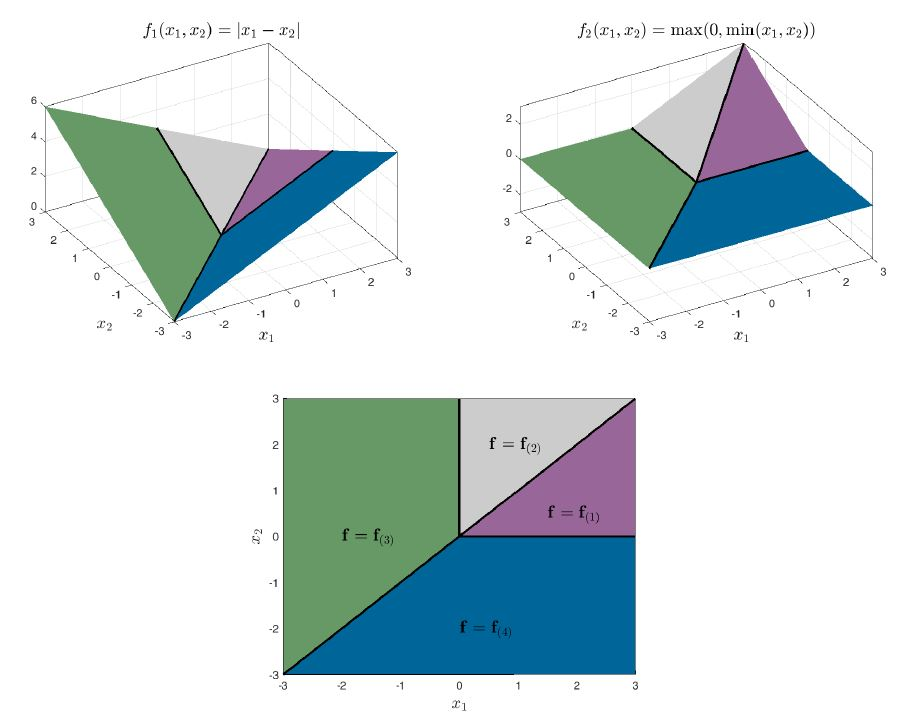
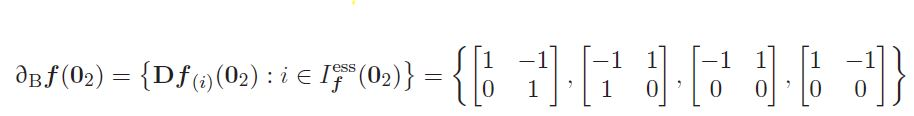

In [ ]:
nsVec1(x) = [abs(x[1]-x[2]);max(0,min(x[1],x[2]))]

ForwardDiff fails to give a useful element of the B-subdifferential or Clarke Jacobian:

In [ ]:
x = [0,0]
ForwardDiff.jacobian(nsVec1,x)

But nsdiff returns an element of the B-subdifferential:

In [ ]:
y = var([0,0])

In [ ]:
a = @nsdiff nsVec1(y)

In [ ]:
@jacobian a

Changing the direction matrix changes the element of the B-subdifferential that is returned:

In [ ]:
M = [-1 0; 0 -1]
b = @nsdiff nsVec1(y) M
@jacobian b M

In [ ]:
function nsVec2(x)
    x1 = x[1]
    x2 = x[2]
    f1 = mid(x1+1,0,x1-1)
    f2 = mid(x2+1,x2-x1,x2-1)
    [f1,f2]
end

In [ ]:
M = [0 -1; -1 0]
x = var([-1,-1])
@nsdiff c = nsVec2(x)
@jacobian c